# install packages & attach drive

In [ ]:
!pip install -q matplotlib
!pip install -q nflows==0.14
!pip install -q pandas==2.0.3
!pip install -q prdc==0.2
!pip install -q protobuf==4.23.4
!pip install -q pytorch-fid==0.2.1
!pip install -q tensorboardx==2.6.2
!pip install -q h5py==3.9.0
!pip install -U tensorboard-plugin-profile
!pip install vocos
import torch
import torchaudio
from torch import nn
import IPython
from vocos import Vocos
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Attach Drive
from google.colab import drive
drive.mount('/content/drive2')

Mounted at /content/drive2


# Define Mel Feature Extractor`



In [3]:
# code adapted from https://github.com/gemelo-ai/vocos/tree/main

def safe_log(x: torch.Tensor, clip_val: float = 1e-7) -> torch.Tensor:
    """
    Computes the element-wise logarithm of the input tensor with clipping to avoid near-zero values.

    Args:
        x (Tensor): Input tensor.
        clip_val (float, optional): Minimum value to clip the input tensor. Defaults to 1e-7.

    Returns:
        Tensor: Element-wise logarithm of the input tensor with clipping applied.
    """
    return torch.log(torch.clip(x, min=clip_val))

class FeatureExtractor(nn.Module):
    """Base class for feature extractors."""

    def forward(self, audio: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Extract features from the given audio.

        Args:
            audio (Tensor): Input audio waveform.

        Returns:
            Tensor: Extracted features of shape (B, C, L), where B is the batch size,
                    C denotes output features, and L is the sequence length.
        """
        raise NotImplementedError("Subclasses must implement the forward method.")

class MelSpectrogramFeatures(FeatureExtractor):
    def __init__(self, sample_rate=22050, n_fft=1024, hop_length=256, n_mels=100, padding="center"):
        super().__init__()
        if padding not in ["center", "same"]:
            raise ValueError("Padding must be 'center' or 'same'.")
        self.padding = padding
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            center=padding == "center",
            power=1,
        )

    def extract(self, audio, **kwargs):
        if self.padding == "same":
            pad = self.mel_spec.win_length - self.mel_spec.hop_length
            audio = torch.nn.functional.pad(audio, (pad // 2, pad // 2), mode="reflect")
        mel = self.mel_spec(audio)
        features = safe_log(mel)
        return features

def imgSpec(ms_feature):
    # ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    print(ms_feature.shape)
    fig, ax = plt.subplots(figsize=(8,4))
    img = librosa.display.specshow(ms_feature.numpy(), x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    plt.show()

# Vocoder Test

torch.Size([100, 49])


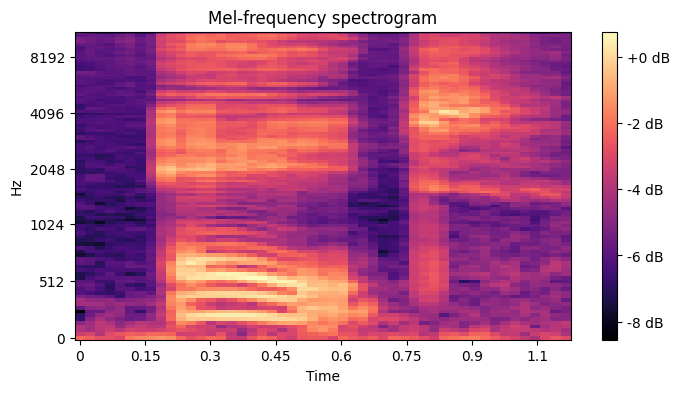

In [ ]:
waveform, sample_rate = librosa.load("/content/drive/MyDrive/PatRecProj/audio-mnist/audio/01/8_01_0.wav")
waveform = torch.tensor(waveform)
waveform = waveform[None, :]
IPython.display.Audio(waveform, rate=sample_rate)
# generate mel features
transform = MelSpectrogramFeatures()
mel_specgram = transform.extract(waveform)
imgSpec(mel_specgram[0])
IPython.display.Audio(waveform, rate=sample_rate)

torch.Size([100, 65])


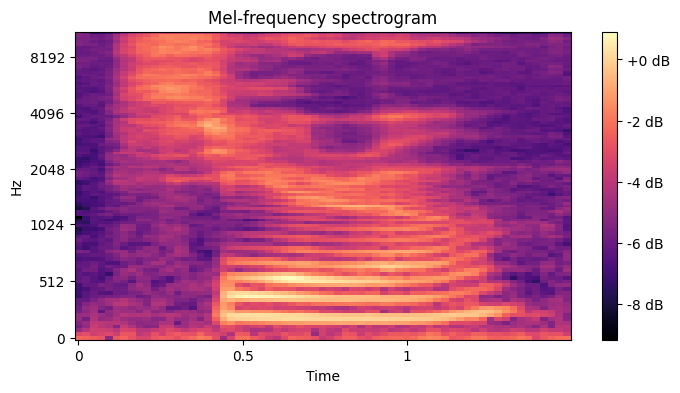

In [ ]:
# load waveform
waveform, sample_rate = librosa.load("/content/drive/MyDrive/PatRecProj/audio-mnist/audio/01/0_01_0.wav")
waveform = torch.tensor(waveform)
waveform = waveform[None, :]
# generate mel features
transform = MelSpectrogramFeatures()
mel_specgram = transform.extract(waveform)
imgSpec(mel_specgram[0])
IPython.display.Audio(waveform, rate=sample_rate)

In [ ]:
vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.yaml:   0%|          | 0.00/461 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.4M [00:00<?, ?B/s]

In [ ]:
# Vocoder test
vocos_waveform  = vocos.decode(mel_specgram)
IPython.display.Audio(vocos_waveform, rate=22050)

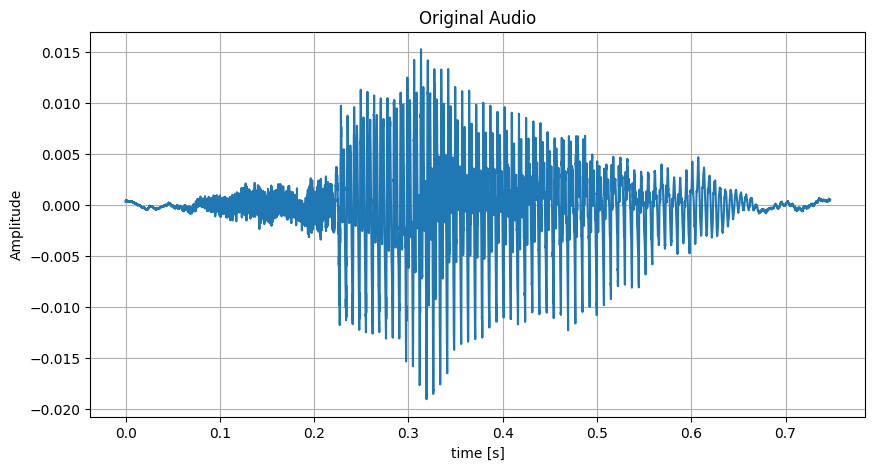

In [ ]:
# Original audio
sample_rate = 22050
duration = waveform.shape[1] /sample_rate
t = np.arange(0, duration, 1/sample_rate)
plt.subplots(figsize=(10,5))
plt.xlabel('time [s]')
plt.ylabel('Amplitude')
plt.title('Original Audio')
plt.plot(t,waveform[0])
plt.grid()
plt.show()

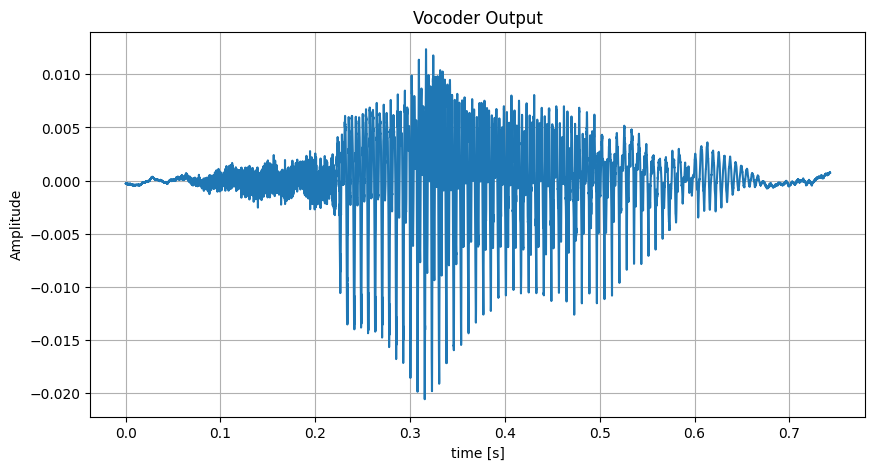

In [ ]:
# Vocoder output
duration = vocos_waveform.shape[1] /sample_rate
t = np.arange(0, duration, 1/sample_rate)
plt.subplots(figsize=(10,5))
plt.xlabel('time [s]')
plt.ylabel('Amplitude')
plt.title('Vocoder Output')
plt.plot(t,vocos_waveform[0])
plt.grid()
plt.show()

# Dataset Preprocessing

In [ ]:
!find /content/drive/MyDrive/PatRecProj/audio-mnist/spectrograms -type f | wc -l

0


In [ ]:
# !rm -r /content/drive/MyDrive/PatRecProj/audio-mnist/spectrograms/*

In [ ]:
# code adapted from https://github.com/musikalkemist/generating-sound-with-neural-networks/tree/main

"""
1- load a file
2- pad the signal (if necessary)
3- extracting log spectrogram from signal
4- normalise spectrogram
5- save the normalised spectrogram

PreprocessingPipeline
"""
import os
import pickle
import librosa
import numpy as np


class Loader:
    """Loader is responsible for loading an audio file."""

    def __init__(self, sample_rate, duration, mono):
        self.sample_rate = sample_rate
        self.duration = duration
        self.mono = mono

    def load(self, file_path):
        signal = librosa.load(file_path,
                              sr=self.sample_rate,
                              duration=self.duration,
                              mono=self.mono)[0]
        return signal


class Padder:
    """Padder is responsible to apply padding to an array."""

    def __init__(self, mode="constant"):
        self.mode = mode

    def left_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (num_missing_items, 0),
                              mode=self.mode)
        return padded_array

    def right_pad(self, array, num_missing_items):
        padded_array = np.pad(array,
                              (0, num_missing_items),
                              mode=self.mode)
        return padded_array


class LogSpectrogramExtractor:
    """LogSpectrogramExtractor extracts log spectrograms (in dB) from a
    time-series signal.
    """

    def __init__(self, frame_size, hop_length):
        self.frame_size = frame_size
        self.hop_length = hop_length

    def extract(self, signal):
        stft = librosa.stft(signal,
                            n_fft=self.frame_size,
                            hop_length=self.hop_length)[:-1]
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram


class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array


class Saver:
    """saver is responsible to save features, and the min max values."""

    def __init__(self, feature_save_dir, min_max_values_save_dir):
        self.feature_save_dir = feature_save_dir
        self.min_max_values_save_dir = min_max_values_save_dir

    def save_feature(self, feature, file_path):
        save_path = self._generate_save_path(file_path)
        np.save(save_path, feature)

    def save_min_max_values(self, min_max_values):
        save_path = os.path.join(self.min_max_values_save_dir,
                                 "min_max_values.pkl")
        self._save(min_max_values, save_path)

    @staticmethod
    def _save(data, save_path):
        with open(save_path, "wb") as f:
            pickle.dump(data, f)

    def _generate_save_path(self, file_path):
        file_name = os.path.split(file_path)[1]
        save_path = os.path.join(self.feature_save_dir, file_name + ".npy")
        return save_path


class PreprocessingPipeline:
    """PreprocessingPipeline processes audio files in a directory, applying
    the following steps to each file:
        1- load a file
        2- pad the signal (if necessary)
        3- extracting log spectrogram from signal
        4- normalise spectrogram
        5- save the normalised spectrogram

    Storing the min max values for all the log spectrograms.
    """

    def __init__(self):
        self.padder = None
        self.extractor = None
        self.normaliser = None
        self.saver = None
        self.min_max_values = {}
        self._loader = None
        self._num_expected_samples = None

    @property
    def loader(self):
        return self._loader

    @loader.setter
    def loader(self, loader):
        self._loader = loader
        self._num_expected_samples = int(loader.sample_rate * loader.duration)

    def process(self, audio_files_dir):
        for root, _, files in os.walk(audio_files_dir):
            for file in files:
                file_path = os.path.join(root, file)
                if file_path.lower().endswith(".wav"):
                  self._process_file(file_path)
            print(f"Processed all files in folder: {root}")
        self.saver.save_min_max_values(self.min_max_values)

    def _process_file(self, file_path):

        signal = self.loader.load(file_path)
        if self._is_padding_necessary(signal):
            signal = self._apply_padding(signal)
        signal = torch.tensor(signal)
        feature = self.extractor.extract(signal)
        # norm_feature = self.normaliser.normalise(feature)
        save_path = self.saver.save_feature(feature, file_path)
        self._store_min_max_value(save_path, feature.min(), feature.max())

    def _is_padding_necessary(self, signal):
        if len(signal) < self._num_expected_samples:
            return True
        return False

    def _apply_padding(self, signal):
        num_missing_samples = self._num_expected_samples - len(signal)
        padded_signal = self.padder.right_pad(signal, num_missing_samples)
        return padded_signal

    def _store_min_max_value(self, save_path, min_val, max_val):
        self.min_max_values[save_path] = {
            "min": min_val,
            "max": max_val
        }

if __name__ == "__main__":
    FRAME_SIZE = 512
    HOP_LENGTH = 256
    DURATION = 0.74  # in seconds
    SAMPLE_RATE = 22050
    MONO = True

    SPECTROGRAMS_SAVE_DIR = "/content/drive/MyDrive/PatRecProj/audio-mnist/spectrograms_new"
    MIN_MAX_VALUES_SAVE_DIR = "/content/drive/MyDrive/PatRecProj/audio-mnist"
    FILES_DIR = "/content/drive/MyDrive/PatRecProj/audio-mnist/audio"

    # instantiate all objects
    loader = Loader(SAMPLE_RATE, DURATION, MONO)
    padder = Padder()
    spectrogram_extractor = MelSpectrogramFeatures()
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver = Saver(SPECTROGRAMS_SAVE_DIR, MIN_MAX_VALUES_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver

    preprocessing_pipeline.process(FILES_DIR)

In [ ]:
import os

def count_files(folder_path):
    if not os.path.isdir(folder_path):
        return "Invalid folder path"

    file_count = 0
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

print("Number of files in folder:", count_files("/content/drive2/MyDrive/PatRecProj/UoMH/data/audio-mnist/spectrograms/train"))


Number of files in folder: 6571


In [ ]:
import glob

# Directory containing the .npy files
directory = '/content/drive2/MyDrive/PatRecProj/UoMH/data/audio-mnist/spectrograms/train'

# Pattern to match .npy files
pattern = '*.npy'

# Get list of .npy files in the directory
npy_files = glob.glob(os.path.join(directory, pattern))

# Count the number of .npy files
num_npy_files = len(npy_files)

print("Number of .npy files:", num_npy_files)


Number of .npy files: 6571


# Push to git

In [ ]:
import os
os.chdir('/content/UoMH')
!git init
!git config --global user.email "gnicksb@gmail.com>"
!git config --global user.name "<NikYian>"
!git add .
!git commit -m "commit"
!git push https://@github.com/SteliosZ1312/patrec_project.git

Reinitialized existing Git repository in /content/UoMH/.git/
[master e79998b] commit
 2 files changed, 11552758 deletions(-)
 create mode 100644 profiler_logs.zip
 delete mode 100644 profiler_logs/vae/c1ad3358d0c3_3595.1705335300861260918.pt.trace.json
Enumerating objects: 103, done.
Counting objects: 100% (103/103), done.
Delta compression using up to 2 threads
Compressing objects: 100% (84/84), done.
Writing objects: 100% (85/85), 48.24 MiB | 5.55 MiB/s, done.
Total 85 (delta 16), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (16/16), completed with 15 local objects.
remote: error: Trace: 6e51179e19568e19241e0b912afb84c4c98b79cb609840f96ff3974b9172753c
remote: error: See https://gh.io/lfs for more information.
remote: error: File profiler_logs/vae/c1ad3358d0c3_3595.1705335300861260918.pt.trace.json is 452.43 MB; this exceeds GitHub's file size limit of 100.00 MB
remote: error: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs